<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/collab_kaggle_beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
target_col = "BeatsPerMinute"
y = train[target_col]
train = train.drop(columns=[target_col])
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test], axis=0)
df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,is_train
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,1
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,1
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,1
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,1
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,1


In [4]:
df.shape

(698886, 10)

In [5]:
df.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,is_train
count,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000
mean,0.632780,-8.378635,0.074451,0.262910,0.117619,0.178378,0.555848,241866.203709,0.500828,0.749999
std,0.156982,4.617735,0.049960,0.223065,0.131791,0.118180,0.225665,59270.996893,0.290102,0.433013
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,0.000000
25%,0.515768,-11.551713,0.023500,0.069421,0.000001,0.077640,0.403898,207099.986725,0.254800,0.250000
50%,0.634682,-8.252704,0.066426,0.242467,0.074202,0.166040,0.564960,243629.488550,0.511867,1.000000
75%,0.739179,-4.909687,0.107329,0.396941,0.203934,0.268884,0.716644,281809.660600,0.746067,1.000000
max,0.975000,-1.357000,0.258857,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,1.000000


In [6]:
df.columns

Index(['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy', 'is_train'],
      dtype='object')

In [7]:
for col in df.select_dtypes(include=[np.number]):
    skew = df[col].skew()
    if skew > 0.7:
        print(f"{col} is positively skewed ({skew:.2f}), consider log1p.")
    elif skew < -0.7:
      print(f"{col} is negatively skewed")
    else:
        print(f"{col} is not skewed")

RhythmScore is not skewed
AudioLoudness is not skewed
VocalContent is positively skewed (0.79), consider log1p.
AcousticQuality is positively skewed (0.79), consider log1p.
InstrumentalScore is positively skewed (1.04), consider log1p.
LivePerformanceLikelihood is not skewed
MoodScore is not skewed
TrackDurationMs is not skewed
Energy is not skewed
is_train is negatively skewed


In [8]:
def add_features(df):
    df["LogInstrumentalScore"] = np.log1p(df["InstrumentalScore"])
    df["LogVocalContent"] = np.log1p(df["VocalContent"])
    df["LogAcousticQuality"] = np.log1p(df["AcousticQuality"])

    df["VocalToInstrumental"] = df["LogVocalContent"] / (df["LogInstrumentalScore"])
    df["RhythmxEnergy"] = df["RhythmScore"] * df["Energy"]

    df["LogVocalToInstrumental"] = np.log1p(df["VocalToInstrumental"])
    df["LogRhythmxEnergy"] = np.log1p(df["RhythmxEnergy"])

    df["Duration_Bin"] = pd.qcut(df["TrackDurationMs"], 5, labels=False)
    df["Energy_Bin"] = pd.qcut(df["Energy"], 5, labels=False)

    df.drop(columns=['InstrumentalScore', 'VocalContent', 'AcousticQuality', 'VocalToInstrumental', 'RhythmxEnergy'], inplace=True)

    return df

df = add_features(df)
for col in df.select_dtypes(include=[np.number]):
    skew = df[col].skew()
    if skew > 1:
        print(f"{col} is skewed ({skew:.2f}), consider log1p.")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698886 entries, 0 to 698885
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                698886 non-null  float64
 1   AudioLoudness              698886 non-null  float64
 2   LivePerformanceLikelihood  698886 non-null  float64
 3   MoodScore                  698886 non-null  float64
 4   TrackDurationMs            698886 non-null  float64
 5   Energy                     698886 non-null  float64
 6   is_train                   698886 non-null  int64  
 7   LogInstrumentalScore       698886 non-null  float64
 8   LogVocalContent            698886 non-null  float64
 9   LogAcousticQuality         698886 non-null  float64
 10  LogVocalToInstrumental     698886 non-null  float64
 11  LogRhythmxEnergy           698886 non-null  float64
 12  Duration_Bin               698886 non-null  int64  
 13  Energy_Bin                 698886 

In [10]:
df.describe()

,RhythmScore,AudioLoudness,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,is_train,LogInstrumentalScore,LogVocalContent,LogAcousticQuality,LogVocalToInstrumental,LogRhythmxEnergy,Duration_Bin,Energy_Bin
count,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000,698886.000000
mean,0.632780,-8.378635,0.178378,0.555848,241866.203709,0.500828,0.749999,0.104688,0.070752,0.218630,3.975823,0.259258,1.999977,1.999757
std,0.156982,4.617735,0.118180,0.225665,59270.996893,0.290102,0.433013,0.112341,0.045748,0.170040,4.905899,0.147035,1.414223,1.414188
min,0.076900,-27.509725,0.024300,0.025600,63973.000000,0.000067,0.000000,0.000001,0.023228,0.000005,0.036964,0.000034,0.000000,0.000000
25%,0.515768,-11.551713,0.077640,0.403898,207099.986725,0.254800,0.250000,0.000001,0.023228,0.067117,0.275561,0.141269,1.000000,1.000000
50%,0.634682,-8.252704,0.166040,0.564960,243629.488550,0.511867,1.000000,0.071578,0.064313,0.217099,0.687068,0.260676,2.000000,2.000000
75%,0.739179,-4.909687,0.268884,0.716644,281809.660600,0.746067,1.000000,0.185595,0.101951,0.334285,9.985507,0.365549,3.000000,3.000000
max,0.975000,-1.357000,0.599924,0.978000,464723.228100,1.000000,1.000000,0.625542,0.230205,0.690644,12.247588,0.680503,4.000000,4.000000


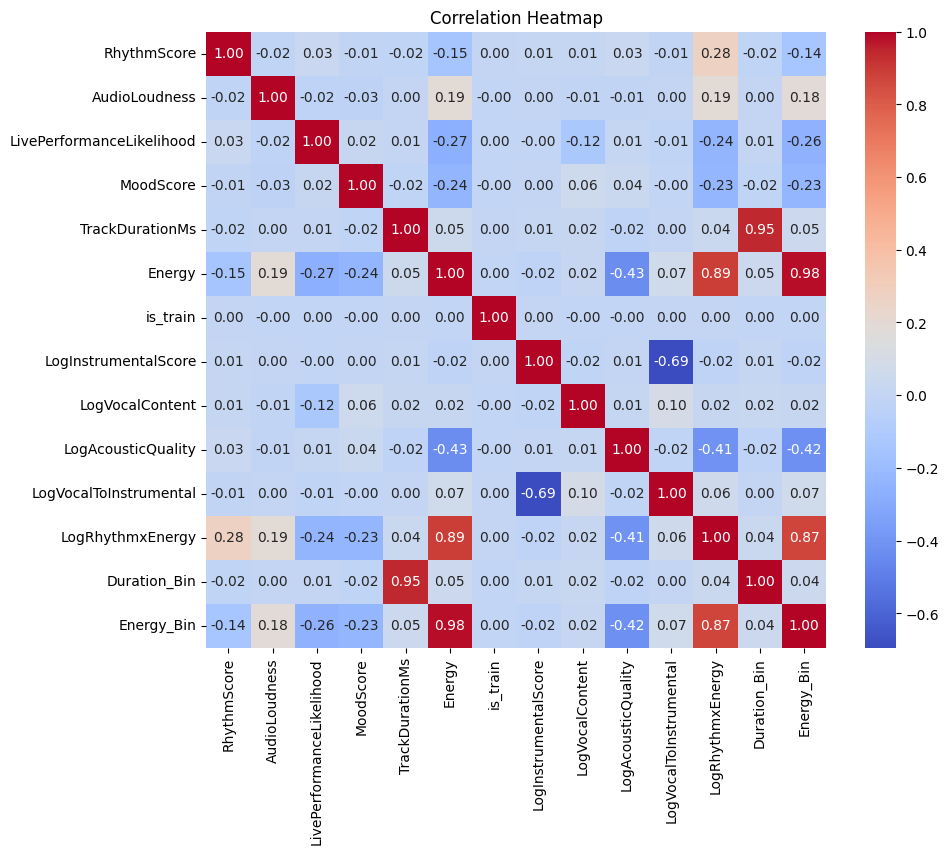

In [11]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [12]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import pointbiserialr, chi2_contingency
from imblearn.pipeline import Pipeline as ImbPipeline

In [13]:
train = df[df["is_train"] == 1].copy()

X = train.drop(columns=["is_train", "LogInstrumentalScore", "LogRhythmxEnergy", "MoodScore", "Energy_Bin"])
# X_encoded = pd.get_dummies(X, drop_first=True)

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": X.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)
mi_df

,Feature,MI Score
5,LogVocalContent,0.003562
6,LogAcousticQuality,0.001585
7,LogVocalToInstrumental,0.001484
4,Energy,0.001189
2,LivePerformanceLikelihood,0.000836
0,RhythmScore,0.000562
3,TrackDurationMs,0.000364
8,Duration_Bin,0.000144
1,AudioLoudness,0.000000


In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)